<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 

import os 
import re 

from functools import reduce 
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mock_sales_data.csv',
 'mall_customers.csv',
 'scanner_data.csv',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 'groceries.csv',
 'sample-sales-data.csv',
 'ecommerce-data.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'online_retail_II.xlsx',
 'sales.csv',
 '1_customers_dataset.csv',
 '1_orders_dataset.csv',
 'test.csv',
 'sales_data_with_stores.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sample_data']

In [4]:
df = pd.read_csv('KPMG_VI_New_raw_data_update_final.csv')
df = df[df.order_status == 'Approved']
df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
0,1,2,2950,25-02-2017,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0
1,2,3,3120,21-05-2017,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0
2,3,37,402,16-10-2017,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0
3,4,88,3135,31-08-2017,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0
4,5,78,787,01-10-2017,True,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0


In [7]:
df.transaction_date = pd.to_datetime(df.transaction_date, infer_datetime_format= True)
df['date'] = df.transaction_date.to_numpy().astype('datetime64[D]')
df['week'] = df.transaction_date.to_numpy().astype('datetime64[W]')
df = df[['customer_id', 'date', 'week', 'list_price']].rename(columns = {'customer_id':'id', 'list_price':'rev'})
df = df.groupby(['id', 'date', 'week'])['rev'].sum().reset_index()
df.head()

,id,date,week,rev
0,1,2017-01-05,2017-01-05,360.40
1,1,2017-02-21,2017-02-16,71.49
2,1,2017-03-27,2017-03-23,688.63
3,1,2017-03-29,2017-03-23,1274.93
4,1,2017-04-06,2017-04-06,1577.53


In [9]:
df2 = df.groupby(['id','week'])['rev'].sum().reset_index().sort_values(['id','week'])
df2.head()

,id,week,rev
0,1,2017-01-05,360.40
1,1,2017-02-16,71.49
2,1,2017-03-23,1963.56
3,1,2017-04-06,1577.53
4,1,2017-05-11,1720.70


In [17]:
list_week = df2['week'].sort_values().unique()
list_npu = df2.groupby(['id']).head()
list_npu.head()

,id,week,rev
0,1,2017-01-05,360.40
1,1,2017-02-16,71.49
2,1,2017-03-23,1963.56
3,1,2017-04-06,1577.53
4,1,2017-05-11,1720.70


In [54]:
# weeks = list_week[0]

res = list()

for weeks in list_week : 
  temp_npu = list_npu[list_npu['week'] == weeks]
  temp_pu = df2[df2['id'].isin(temp_npu['id'])].sort_values(['id','week'])
  temp_pu['npu_week'] = np.repeat(weeks, len(temp_pu))
  temp_pu['diff'] = (temp_pu['week'] - temp_pu['npu_week']).dt.days // 7
  temp_pu['flag'] = 1
  temp_pu = temp_pu[['id', 'npu_week', 'diff', 'flag']]
  temp = pd.pivot_table(temp_pu, index = ['id', 'npu_week'], columns = 'diff', values = 'flag').reset_index()
  temp = pd.melt(temp, id_vars = ['id', 'npu_week'], var_name = 'weeks', value_name='flag')
  temp = temp.groupby(['npu_week', 'weeks'])['flag'].sum().reset_index().rename(columns = {'flag':'pu'}).sort_values(['npu_week', 'weeks'])
  temp['ratio'] = temp.groupby(['npu_week'])['pu'].apply(lambda x : round(x/x.max() * 100 , 2))
  
  temp['npu_week'] = temp['npu_week'].astype(str)
  temp = temp[temp['weeks'] >= 0]
  
  res.append(temp)

res = pd.concat(res)
res.head()

,npu_week,weeks,pu,ratio
0,2016-12-29,0,208.0,100.00
1,2016-12-29,1,20.0,9.62
2,2016-12-29,2,12.0,5.77
3,2016-12-29,3,25.0,12.02
4,2016-12-29,4,18.0,8.65


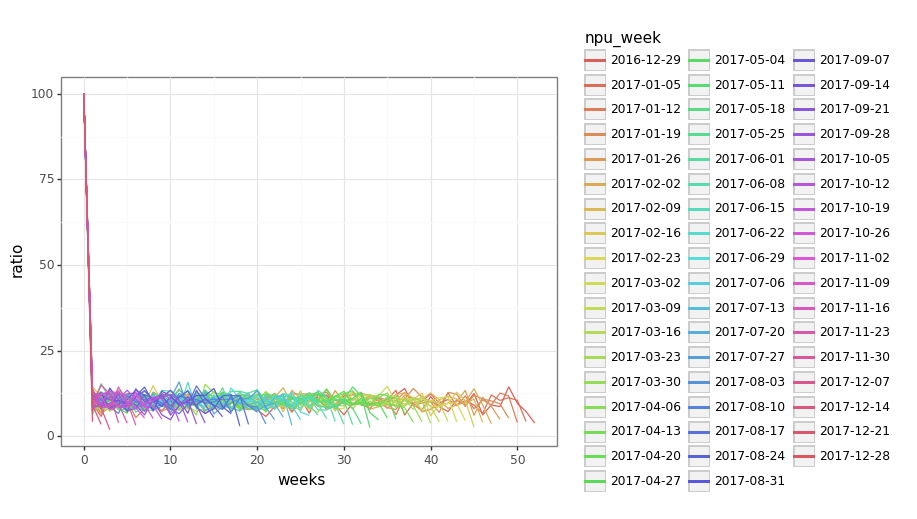

<ggplot: (8753143135549)>

In [55]:
(
    ggplot(res.assign(npu_week = res['npu_week'].astype(str)), aes('weeks', 'ratio', color = 'npu_week')) +
    gg.geom_line() +
    gg.theme_bw()
)

# Iterators

In [60]:
from string import ascii_lowercase as lw
lt = list(lw) + list(range(10))

names = ['park', 'ji', 'kang']
email1 = [''.join(np.random.choice(lt, 10, replace = True)) for a in range(3)]
email2 = [''.join(np.random.choice(lt, 5, replace = True)) for a in range(3)]
email = [a + '@' + b + np.random.choice(['.com', '.net', '.co.kr'], 1)[0] for a, b in zip(email1, email2)]
age = np.random.randint(20, 40, 3)
score = np.random.randint(200, 500, 3)

In [71]:
[ {k : list(v) } for k, v in dict(zip(names, zip(email, age, score))).items()]

[{'park': ['awzspx7bm4@vq7b2.net', 22, 249]},
 {'ji': ['d6qu2o0xkd@ctlst.net', 33, 456]},
 {'kang': ['pb98zpe2ng@wqzdx.net', 31, 269]}]